In [1]:

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors

Z_GAP = 10 # in cm
SC_Ymgap = 0
N_PARAMS = 14


def CreateArb8(arbName, medium, dZ, corners, magField, field_profile,
               tShield, x_translation, y_translation, z_translation, stepGeo):

    corners /= 100
    dZ /= 100
    z_translation /= 100

    tShield['components'].append({
        'corners' : corners.tolist(),
        'field_profile' : field_profile,
        'field' : magField,
        'name': arbName,
        'dz' : dZ,
        "z_center" : z_translation,
    })
def CreateTarget(z_start:float):
    target_components = []
    N = 13
    T = 5
    materials = N * ["G4_Mo"] + T * ["G4_W"]
    lengths = [8., 2.5, 2.5, 2.5, 2.5, 
        2.5, 2.5, 2.5, 5.0, 5.0, 
        6.5, 8., 8., 5., 8., 
        10., 20., 35.]
    h20_l = 0.5 / 100 # H20 slit *17 times
    diameter  = 30. / 100  # full length in x and y
    z = z_start
    for i in range(N+T):
        L = lengths[i]/100
        if i!=0:
            target_components.append({
            "radius": diameter / 2,
            "dz": h20_l,
            "z_center": z + h20_l/2,
            "material": "G4_WATER",
            })
            z += h20_l
        target_components.append({
            "radius": diameter / 2,
            "dz": L,
            "z_center": z + L/2,
            "material": materials[i],
        })
        z += L
    return target_components

def CreateCavern(shift = 0, length:float = 90.):
    cavern = []
    def cavern_components(x_translation, 
               y_translation, 
               dX,
               dY,
               external_rock):
        x1 = x_translation - dX
        x2 = x_translation + dX
        y1 = y_translation - dY
        y2 = y_translation + dY
        corners_up = np.tile(np.array([[x2, y2],
               [x1, y2],
               [x1, external_rock[1]],
               [x2, external_rock[1]]]).flatten(), 2).tolist()
        corners_right = np.tile(np.array([[x2, -external_rock[1]],
              [x2, external_rock[1]],
              [external_rock[0], external_rock[1]],
              [external_rock[0], -external_rock[1]]]).flatten(), 2).tolist()
        corners_left = np.tile(np.array([[x1, -external_rock[1]],
             [-external_rock[0], -external_rock[1]],
             [-external_rock[0], external_rock[1]],
             [x1, external_rock[1]]]).flatten(), 2).tolist()
        corners_down = np.tile(np.array([[x1, y1],
             [x2, y1],
             [x2, -external_rock[1]],
             [x1, -external_rock[1]]]).flatten(), 2).tolist()
        return [corners_up,corners_right,corners_left,corners_down]
    external_rock = (15,15) #entire space is 40x40

    TCC8_length = max(length, 170.)
    dX_TCC8 = 5
    dY_TCC8 = 3.75
    TCC8_shift = (1.43,2.05,-TCC8_length/2)

    ECN3_length = max(length, 100.)
    dX_ECN3 = 8
    dY_ECN3 = 7
    ECN3_shift = (3.43,3.64, ECN3_length/2)


    TCC8 = {"material": "G4_CONCRETE",
            "name": 'TCC8',
            "dz": TCC8_length/2,
            "z_center" : TCC8_shift[2]+shift,
            "components" : []}
    TCC8["components"] = cavern_components(*TCC8_shift[:2],dX_TCC8,dY_TCC8,external_rock)
    cavern.append(TCC8)

    ECN3 = {"material": "G4_CONCRETE",
            "name": 'ECN3',
            "dz" : ECN3_length/2,
            "z_center" : ECN3_shift[2]+shift,
            "components" : []}
    ECN3["components"] = cavern_components(*ECN3_shift[:2],dX_ECN3,dY_ECN3,external_rock)
    cavern.append(ECN3)

    return cavern

# fields should be 4x3 np array
def create_magnet(magnetName, medium, tShield,
                  fields,field_profile, dX,
                  dY, dX2, dY2, dZ, middleGap,
                  middleGap2,ratio_yoke_1, ratio_yoke_2, dY_yoke_1,dY_yoke_2, gap,
                  gap2, Z, stepGeo, Ymgap = 0):
    dY += Ymgap #by doing in this way, the gap is filled with iron in Geant4, but simplifies
    coil_gap = gap
    coil_gap2 = gap2
    anti_overlap = 0.0# gap between fields in the corners for mitred joints (Geant goes crazy when
    # they touch each other)


    cornersMainL = np.array([
        middleGap, 
        -(dY +dY_yoke_1)- anti_overlap, 
        middleGap, 
        dY + dY_yoke_1- anti_overlap,
        dX + middleGap, 
        dY- anti_overlap, 
        dX + middleGap,
        -(dY- anti_overlap),
        middleGap2,
        -(dY2 + dY_yoke_2- anti_overlap), middleGap2, 
        dY2 + dY_yoke_2- anti_overlap,
        dX2 + middleGap2, 
        dY2- anti_overlap, 
        dX2 + middleGap2,
        -(dY2- anti_overlap)])

    cornersTL = np.array((middleGap + dX,dY,
                            middleGap,
                            dY + dY_yoke_1,
                            dX + ratio_yoke_1*dX + middleGap + coil_gap,
                            dY + dY_yoke_1,
                            dX + middleGap + coil_gap,
                            dY,
                            middleGap2 + dX2,
                            dY2,
                            middleGap2,
                            dY2 + dY_yoke_2,
                            dX2 + ratio_yoke_2*dX2 + middleGap2 + coil_gap2,
                            dY2 + dY_yoke_2,
                            dX2 + middleGap2 + coil_gap2,
                            dY2))

    cornersMainSideL = np.array((dX + middleGap + gap,
                                 -(dY), 
                                 dX + middleGap + gap,
                                dY, 
                                dX + ratio_yoke_1*dX + middleGap + gap, 
                                dY + dY_yoke_1,
                                dX + ratio_yoke_1*dX + middleGap + gap, 
                                -(dY + dY_yoke_1), 
                                dX2 + middleGap2 + gap2,
                                -(dY2), 
                                dX2 + middleGap2 + gap2, 
                                dY2,
                                dX2 + ratio_yoke_2*dX2 + middleGap2 + gap2, 
                                dY2 + dY_yoke_2, 
                                dX2 + ratio_yoke_2*dX2 + middleGap2 + gap2,
                                -(dY2 + dY_yoke_2)))

    
    cornersMainR = np.zeros(16, np.float16)
    cornersCLBA = np.zeros(16, np.float16)
    cornersMainSideR = np.zeros(16, np.float16)
    cornersCLTA = np.zeros(16, np.float16)
    cornersCRBA = np.zeros(16, np.float16)
    cornersCRTA = np.zeros(16, np.float16)

    cornersTR = np.zeros(16, np.float16)
    cornersBL = np.zeros(16, np.float16)
    cornersBR = np.zeros(16, np.float16)


    # Use symmetries to define remaining magnets
    for i in range(16):
        cornersMainR[i] = -cornersMainL[i]
        cornersMainSideR[i] = -cornersMainSideL[i]
        cornersCRTA[i] = -cornersCLBA[i]
        cornersBR[i] = -cornersTL[i]

    # Need to change order as corners need to be defined clockwise
    for i in range(8):
        j = (11 - i) % 8
        cornersCLTA[2 * j] = cornersCLBA[2 * i]
        cornersCLTA[2 * j + 1] = -cornersCLBA[2 * i + 1]
        cornersTR[2 * j] = -cornersTL[2 * i]
        cornersTR[2 * j + 1] = cornersTL[2 * i + 1]

    for i in range(16):
        cornersCRBA[i] = -cornersCLTA[i]
        cornersBL[i] = -cornersTR[i]

    str1L = "_MiddleMagL"
    str1R = "_MiddleMagR"
    str2 = "_MagRetL"
    str3 = "_MagRetR"
    str4 = "_MagCLB"
    str5 = "_MagCLT"
    str6 = "_MagCRT"
    str7 = "_MagCRB"
    str8 = "_MagTopLeft"
    str9 = "_MagTopRight"
    str10 = "_MagBotLeft"
    str11 = "_MagBotRight"

    stepGeo = False

    theMagnet = {
        'components' : [],
        'dz' : dZ/100,
        'z_center' : Z/100,
    }

    if field_profile == 'uniform':
        CreateArb8(magnetName + str1L, medium, dZ, cornersMainL, fields[0], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str1R, medium, dZ, cornersMainR, fields[0], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str2, medium, dZ, cornersMainSideL, fields[1], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str3, medium, dZ, cornersMainSideR, fields[1], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str8, medium, dZ, cornersTL, fields[3], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str9, medium, dZ, cornersTR, fields[2], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str10, medium, dZ, cornersBL, fields[2], field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str11, medium, dZ, cornersBR, fields[3], field_profile, theMagnet, 0, 0, Z, stepGeo)

    else:
        CreateArb8(magnetName + str1L, medium, dZ, cornersMainL, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str1R, medium, dZ, cornersMainR, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str2, medium, dZ, cornersMainSideL, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str3, medium, dZ, cornersMainSideR, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str8, medium, dZ, cornersTL, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str9, medium, dZ, cornersTR, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str10, medium, dZ, cornersBL, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
        CreateArb8(magnetName + str11, medium, dZ, cornersBR, fields, field_profile, theMagnet, 0, 0, Z, stepGeo)
    

    tShield['magnets'].append(theMagnet)


def construct_block(medium, tShield,field_profile, stepGeo):
    #iron block before the magnet
    z_gap = 1.
    dX = 356.#395.
    dY = 170.#340.
    dZ = 45. - z_gap/2
    Z = -45.
    cornersIronBlock = np.array([
        -dX, -dY,
        dX, -dY,
        dX, dY,
        -dX, dY,
        -dX, -dY,
        dX, -dY,
        dX, dY,
        -dX, dY
    ])
    Block = {
        'components' : [],
        'dz' : dZ/100,
        'z_center' : Z/100,
    }
    #cornersIronBlock = contraints_cavern_intersection(cornersIronBlock/100, dZ/100, Z/100, 22-2.345)
    CreateArb8('IronAfterTarget', medium, dZ, cornersIronBlock, [0.,0.,0.], field_profile, Block, 0, 0, Z, stepGeo)
    tShield['magnets'].append(Block)


def design_muon_shield(params,fSC_mag = True, simulate_fields = False, field_map_file = None, cores_field:int = 1,extra_magnet = False, NI_from_B = True, use_diluted = False):

    
    n_magnets = 7 + int(extra_magnet)
    cm = 1
    m = 100 * cm
    tesla = 1
    zgap = Z_GAP*cm

    magnetName = ["MagnAbsorb2", "Magn1", "Magn2", "Magn3", "Magn4", "Magn5", "Magn6", "Magn7"]

    fieldDirection = ["up", "up", "up", "up", "down", "down", "down", "down"]


    dZ1 = params[0]
    dZ2 = params[1]
    dZ3 = params[2]
    dZ4 = params[3]
    dZ5 = params[4]
    dZ6 = params[5]
    dZ7 = params[6]
    fMuonShieldLength = 2 * (dZ1 + dZ2 + dZ3 + dZ4 + dZ5 + dZ6 + dZ7)+ zgap


    dXIn = np.zeros(n_magnets)
    dXOut = np.zeros(n_magnets)
    gapIn = np.zeros(n_magnets)
    dYIn = np.zeros(n_magnets)
    dYOut = np.zeros(n_magnets)
    gapOut = np.zeros(n_magnets)
    dZf = np.zeros(n_magnets)
    ratio_yokesIn = np.ones(n_magnets)
    ratio_yokesOut = np.ones(n_magnets)
    dY_yokeIn = np.zeros(n_magnets)
    dY_yokeOut = np.zeros(n_magnets)

    Z = np.zeros(n_magnets)
    midGapIn= np.zeros(n_magnets)
    midGapOut= np.zeros(n_magnets)
    NI = np.zeros(n_magnets)


    offset = n_magnets - int(extra_magnet)
    n_params = len(params)/n_magnets - 1
    n_params = 13

    for i in range(n_magnets - int(extra_magnet)):
        dXIn[i] = params[offset + i * n_params]
        dXOut[i] = params[offset + i * n_params + 1]
        dYIn[i] = params[offset + i * n_params + 2]
        dYOut[i] = params[offset + i * n_params + 3]
        gapIn[i] = params[offset + i * n_params + 4]
        gapOut[i] = params[offset + i * n_params + 5]
        ratio_yokesIn[i] = params[offset + i * n_params + 6]
        ratio_yokesOut[i] = params[offset + i * n_params + 7]
        dY_yokeIn[i] = params[offset + i * n_params + 8]
        dY_yokeOut[i] = params[offset + i * n_params + 9]
        midGapIn[i] = params[offset + i * n_params + 10]
        midGapOut[i] = params[offset + i * n_params + 11]
        NI[i] = params[offset + i * n_params + 12]
    dZf[0] = dZ1 - zgap / 2
    Z[0] = dZf[0]
    dZf[1] = dZ2 - zgap / 2
    Z[1] = Z[0] + dZf[0] + dZf[1] + 2 * zgap
    dZf[2] = dZ3 - zgap / 2
    Z[2] = Z[1] + dZf[1] + dZf[2] + zgap
    dZf[3] = dZ4 - zgap / 2
    Z[3] = Z[2] + dZf[2] + dZf[3] + zgap
    dZf[4] = dZ5 - zgap / 2
    Z[4] = Z[3] + dZf[3] + dZf[4] + zgap
    dZf[5] = dZ6 - zgap / 2
    Z[5] = Z[4] + dZf[4] + dZf[5] + zgap
    dZf[6] = dZ7 - zgap / 2
    Z[6] = Z[5] + dZf[5] + dZf[6] + zgap

    if extra_magnet:
        dXIn[7] = dXOut[6] #last small magnet
        dYIn[7] = dYOut[6]
        dXOut[7] = dXIn[7]
        dYOut[7] = dYIn[7]
        gapIn[7] = gapOut[6]
        gapOut[7] = gapIn[7]
        ratio_yokesIn[7] = ratio_yokesOut[6]
        ratio_yokesOut[7] = ratio_yokesIn[7]
        dY_yokeIn[7] = dY_yokeOut[6]
        dY_yokeOut[7] = dY_yokeIn[7]
        midGapIn[7] = midGapOut[6]
        midGapOut[7] = midGapIn[7]
        NI[7] = NI[6]
        dZf[7] = 0.1 * m
        Z[7] = Z[6] + dZf[6] + dZf[7]
        fMuonShieldLength += dZf[7]

    tShield = {
        'dz': fMuonShieldLength/100,
        'magnets':[],
        'global_field_map': {'B': np.array([])},
    }
    cost = 0
    for nM in range(0,n_magnets):
        if dZf[nM] < 1 or dXIn[nM] < 1: continue
        if fSC_mag and (nM in [1,3]):
            continue
        if nM == 2 and fSC_mag:
            Ymgap = SC_Ymgap*cm
            ironField_s = 5.1 * tesla
        elif nM == 0:
            Ymgap = 0
            ironField_s = 1.9 * tesla
        else:
            Ymgap = 0
            ironField_s = 1.9 * tesla

        if simulate_fields or field_map_file is not  None:
            field_profile = 'global'
            fields_s = [[],[],[]]
        else:
            field_profile = 'uniform'
            if fieldDirection[nM] == "down":
                ironField_s = -ironField_s
            if nM in [4,5,6]: ironField_s *= ratio_yokesIn[nM]
            magFieldIron_s = [0., ironField_s, 0.]
            RetField_s = [0., -ironField_s/ratio_yokesIn[nM], 0.]
            ConRField_s = [-ironField_s/ratio_yokesIn[nM], 0., 0.]
            ConLField_s = [ironField_s/ratio_yokesIn[nM], 0., 0.]
            fields_s = [magFieldIron_s, RetField_s, ConRField_s, ConLField_s]

        create_magnet(magnetName[nM], "G4_Fe", tShield, fields_s, field_profile, dXIn[nM], dYIn[nM], dXOut[nM],
              dYOut[nM], dZf[nM], midGapIn[nM], midGapOut[nM], ratio_yokesIn[nM], ratio_yokesOut[nM],
              dY_yokeIn[nM], dY_yokeOut[nM], gapIn[nM], gapOut[nM], Z[nM], False, Ymgap=Ymgap)
    field_profile = 'global' if simulate_fields else 'uniform'
    construct_block("G4_Fe", tShield, field_profile, False)
    return tShield





def get_design_from_params(params, 
                           fSC_mag:bool = True, 
                           force_remove_magnetic_field = False,
                           simulate_fields = False,
                           field_map_file = None,
                           sensitive_film_params:dict = {'dz': 0.01, 'dx': 4, 'dy': 6,'position':82},
                           add_cavern:bool = True,
                           add_target:bool = True,
                           cores_field:int = 1,
                           extra_magnet = False,
                           NI_from_B = True, 
                           use_diluted = False):
    params = np.round(params, 2)
    shield = design_muon_shield(params, fSC_mag, simulate_fields = simulate_fields, field_map_file = field_map_file, cores_field=cores_field, extra_magnet = extra_magnet, NI_from_B = NI_from_B, use_diluted=use_diluted)
    shift = -2.345
    cavern_transition = 20.518+shift #m
    World_dZ = 200 #m
    World_dX = World_dY = 30 if add_cavern else 15
    if add_cavern: shield["cavern"] = CreateCavern(cavern_transition, length = World_dZ)
    if add_target: shield['target'] = CreateTarget(z_start=shift)
    #z_bias = sensitive_film_params['position']/2
    i=0
    max_z = 0
    for mag in shield['magnets']:
        i+=1
        mag['z_center'] = mag['z_center']
        for x in mag['components']:
            if force_remove_magnetic_field:
                x['field'] = (0.0, 0.0, 0.0)
                x['field_profile'] = 'uniform'
            elif x['field_profile'] not in ['uniform','global']: 
                x['field']['B'] = x['field']['B'].tolist()
            #if add_cavern: x['corners'] = contraints_cavern_intersection(np.array(x['corners']), x['dz'], x['z_center'], cavern_transition).tolist()
        mag['material'] = 'G4_Fe'
        if mag['dz'] + mag['z_center'] > max_z:
            max_z = mag['dz'] + mag['z_center']

    shield.update({
     "worldSizeX": World_dX, "worldSizeY": World_dY, "worldSizeZ": World_dZ,
        "type" : 1,
        "limits" : {
            "max_step_length": 0.05,
            "minimum_kinetic_energy": 0.1,
        },
    })
    if sensitive_film_params is not None:
        shield.update({
            "sensitive_film": {
            "z_center" : sensitive_film_params['position'],
            "dz" : sensitive_film_params['dz'],
            "dx": sensitive_film_params['dx'],
            "dy": sensitive_film_params['dy']}})
    return shield

params = [120.50, 127.5, 250., 372.5, 203.76, 200.59, 198.83, 
            50.00,  50.00, 119.00, 119.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,
            50.00,  50.00, 100.00, 100.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,
            50.00,  50.00, 100.00, 100.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,
            50.00,  50.00, 100.00, 100.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,
            50.00,  50.00, 100.00, 100.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,
            50.00,  50.00, 100.00, 100.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,
            50.00,  50.00, 100.00, 100.00,   2.00,   2.00, 1.00, 1.0, 50.00,  50.00, 0., 0.0, 0.,]
fSC_mag = False
core_field = 8
use_diluted =  False
detector = get_design_from_params(params, simulate_fields=False, add_cavern=True, fSC_mag = fSC_mag, use_diluted = use_diluted)


In [2]:
def _draw_target_on_ax(ax, detector):
    # Copied and adapted from plot_magnet
    if "target" in detector:
        for target_item in detector["target"]:
            z_center = target_item["z_center"]
            dz = target_item["dz"]
            radius = target_item["radius"]
            material = target_item["material"]
            color = 'gray'
            if material == "G4_W": color = 'darkblue'
            elif material == "G4_WATER": color = 'lightblue'
            elif material == "G4_Mo": color = 'brown'
            
            z1, z2 = z_center - dz, z_center + dz
            theta = np.linspace(0, 2 * np.pi, 50) # Reduced points for cylinders
            x_cyl = radius * np.cos(theta)
            y_cyl = radius * np.sin(theta)
            
            top_circle = np.array([z2 * np.ones_like(theta), x_cyl, y_cyl]).T
            bottom_circle = np.array([z1 * np.ones_like(theta), x_cyl, y_cyl]).T
            
            side_faces = []
            for i in range(len(theta) - 1):
                side_faces.append([bottom_circle[i], bottom_circle[i+1], top_circle[i+1], top_circle[i]])
            
            ax.add_collection3d(Poly3DCollection([top_circle], facecolors=color, linewidths=0.01, edgecolors=color, alpha=0.7))
            ax.add_collection3d(Poly3DCollection([bottom_circle], facecolors=color, linewidths=0.01, edgecolors=color, alpha=0.7))
            ax.add_collection3d(Poly3DCollection(side_faces, facecolors=color, linewidths=0.01, edgecolors=color, alpha=0.7))



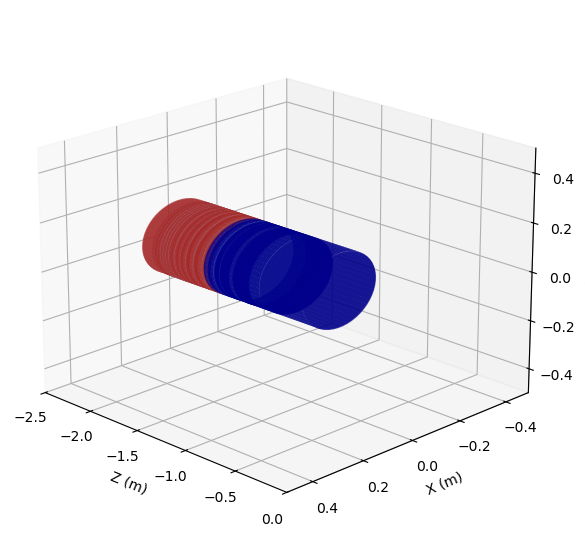

In [3]:
# Ensure the 'detector' variable is defined from the previous cell (cell id: 742cd768)
# and the '_draw_target_on_ax' function is defined (cell id: aa1cc1cd).

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

_draw_target_on_ax(ax, detector) # This function is from your cell 'aa1cc1cd'

# Basic plot cosmetics for viewing
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (m)')
ax.set_zlabel('Y (m)')



ax.set_xlim(0, -2.5)  
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.5, 0.5)

ax.view_init(elev=20, azim=135) # Adjust view angle as preferred
plt.show()



In [4]:
def _draw_all_magnets_on_ax(ax, detector, ignore_magnets_indices=[]):
    """
    Draws all magnet components defined in the detector object onto the given Axes.

    Args:
        ax (matplotlib.axes.Axes): The 3D Axes object to draw on.
        detector (dict): The detector dictionary containing magnet definitions.
        ignore_magnets_indices (list, optional): A list of magnet indices to skip.
                                                 Defaults to None.
    """


    magnets_data = detector['magnets']

    for m_idx, magnet_structure in enumerate(magnets_data):
        if m_idx in ignore_magnets_indices:
            continue

        z_center_val = magnet_structure.get('z_center', 0)
        dz_val = magnet_structure.get('dz', 0)
        z1 = z_center_val - dz_val
        z2 = z_center_val + dz_val

        for component in magnet_structure.get('components', []):
            corners_xy_flat = component.get('corners')
            if not corners_xy_flat or len(corners_xy_flat) != 16:
                # print(f"Warning: Skipping component {component.get('name', 'Unnamed')} due to invalid/missing corners.")
                continue
            
            field_profile = component.get('field_profile', 'uniform')
            field_data = component.get('field', [0., 0., 0.])
            
            # Determine field vector for coloring (simplified from plot_magnet)
            # This assumes 'filter_fields' would be available in the scope if 'global' is used.
            # For a standalone helper, direct use of 'filter_fields' might be problematic
            # if it's not passed or globally available.
            effective_field_vector = np.array([0.,0.,0.])
            if field_profile == 'uniform':
                effective_field_vector = np.asarray(field_data)
            elif isinstance(field_data, (list, np.ndarray)) and len(field_data) > 1 and isinstance(field_data[0], (list, np.ndarray)):
                # Attempt to handle cases where field_data might be a list of vectors or similar
                try:
                    effective_field_vector = np.mean(field_data, axis=0) # Generic attempt
                    if not isinstance(effective_field_vector, np.ndarray) or effective_field_vector.shape != (3,): # check if mean is a 3-vector
                         effective_field_vector = np.array(field_data[0] if field_data else [0.,0.,0.]) # Fallback to first element or default
                except: # Fallback if mean fails
                    effective_field_vector = np.array(field_data[0] if field_data else [0.,0.,0.])
            elif isinstance(field_data, (list, np.ndarray)) and len(field_data) == 3:
                 effective_field_vector = np.asarray(field_data)


            # Determine color based on field
            col = 'grey'
            B_th = 0.7 # Threshold for coloring
            if effective_field_vector.shape == (3,):
                if effective_field_vector[1] < -B_th: col = 'red'
                elif effective_field_vector[1] > B_th: col = 'green'
                elif effective_field_vector[0] < -B_th: col = 'red' # Assuming field[0] is Bx
                elif effective_field_vector[0] > B_th: col = 'green'
                elif effective_field_vector[2] < -B_th: col = 'blue' # Assuming field[2] is Bz (plot Z)
                elif effective_field_vector[2] > B_th: col = 'blue'
            
            # Construct 3D corners for the component
            # corners_xy_flat contains 8 pairs of (x,y) coordinates:
            # First 4 pairs for z1 plane, next 4 pairs for z2 plane.
            # Plotting coordinates: (data_z, data_x, data_y)
            
            vertices_3d = []
            # Vertices for the z1 plane (bottom)
            for i in range(0, 8, 2):
                vertices_3d.append([z1, corners_xy_flat[i], corners_xy_flat[i+1]])
            # Vertices for the z2 plane (top)
            for i in range(8, 16, 2):
                vertices_3d.append([z2, corners_xy_flat[i], corners_xy_flat[i+1]])
            
            vertices_3d = np.array(vertices_3d)

            # Define faces for Poly3DCollection (standard box indexing)
            # Indices 0-3 are for z1 plane, 4-7 for z2 plane
            faces = [
                [vertices_3d[j] for j in [0, 1, 2, 3]],  # Bottom face at z1
                [vertices_3d[j] for j in [4, 5, 6, 7]],  # Top face at z2
                [vertices_3d[j] for j in [0, 1, 5, 4]],  # Side face
                [vertices_3d[j] for j in [1, 2, 6, 5]],  # Side face
                [vertices_3d[j] for j in [2, 3, 7, 6]],  # Side face
                [vertices_3d[j] for j in [3, 0, 4, 7]]   # Side face
            ]
            
            ax.add_collection3d(Poly3DCollection(faces, facecolors=col, linewidths=0.3, edgecolors='darkred', alpha=0.25))



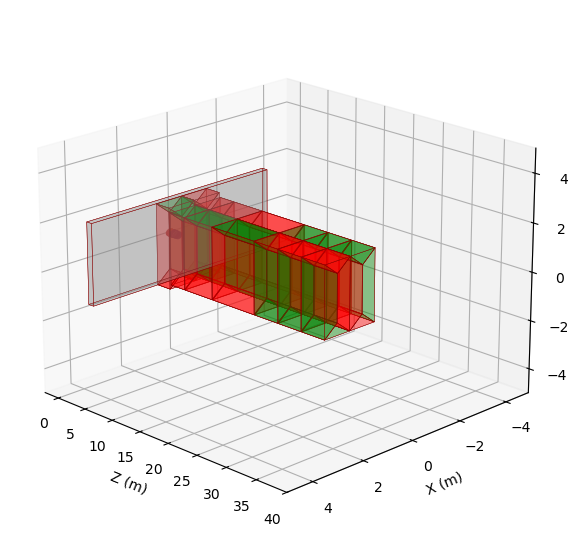

In [5]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

_draw_target_on_ax(ax, detector) 
_draw_all_magnets_on_ax(ax, detector, ignore_magnets_indices=[]) # Ignore all magnets for now
# Basic plot cosmetics for viewing
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (m)')
ax.set_zlabel('Y (m)')



ax.set_xlim(40, -2.5)  
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.view_init(elev=20, azim=135) # Adjust view angle as preferred

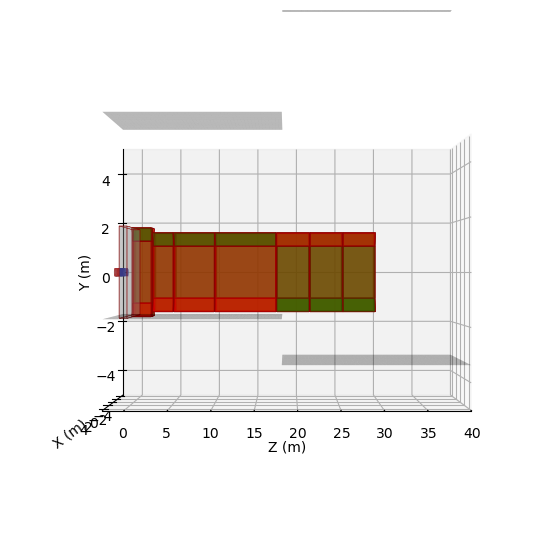

In [6]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

_draw_target_on_ax(ax, detector) 
_draw_all_magnets_on_ax(ax, detector, ignore_magnets_indices=[]) # Ignore all magnets for now
# Basic plot cosmetics for viewing
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (m)')
ax.set_zlabel('Y (m)')



ax.set_xlim(40, -2.5)  
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.view_init(elev=0, azim=90) # Adjust view angle as preferred

z_plane2 = -1.7
z_plane1 = -3.36
x_split = 20.518 - 2.345

# First plane
x_range1 = np.linspace(ax.get_xlim()[0], x_split, 100)
y_range1 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
X1, Y1 = np.meshgrid(x_range1, y_range1)
Z1 = np.full_like(X1, z_plane1)
ax.plot_surface(X1, Y1, Z1, color='black', alpha=0.3)

# Second plane
x_range2 = np.linspace(x_split, ax.get_xlim()[1], 100)
y_range2 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
X2, Y2 = np.meshgrid(x_range2, y_range2)
Z2 = np.full_like(X2, z_plane2)
ax.plot_surface(X2, Y2, Z2, color='black', alpha=0.3)

z_plane2 = 5.8
z_plane1 = 10.6
Z1 = np.full_like(X1, z_plane1)
ax.plot_surface(X1, Y1, Z1, color='black', alpha=0.3)
X2, Y2 = np.meshgrid(x_range2, y_range2)
Z2 = np.full_like(X2, z_plane2)
ax.plot_surface(X2, Y2, Z2, color='black', alpha=0.3)
        
plt.show()

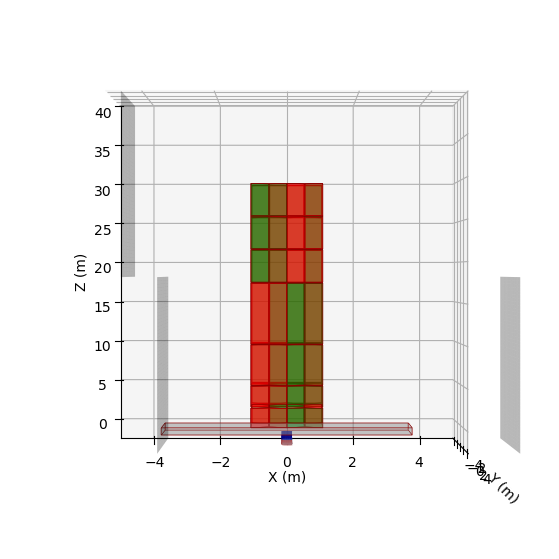

In [12]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

_draw_target_on_ax(ax, detector) 
_draw_all_magnets_on_ax(ax, detector, ignore_magnets_indices=[]) # Ignore all magnets for now
# Basic plot cosmetics for viewing
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (m)')
ax.set_zlabel('Y (m)')



ax.set_xlim(40, -2.5)  
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.view_init(elev=90, azim=0) # Adjust view angle as preferred

y_plane2 = -3.57
y_plane1 = -4.57
x_split = 20.518 - 2.345

# First plane
x_range1 = np.linspace(ax.get_xlim()[0], x_split, 100)
z_range1 = np.linspace(ax.get_zlim()[0], ax.get_zlim()[1], 100)
X1, Z1 = np.meshgrid(x_range1, z_range1)
Y1 = np.full_like(X1, y_plane1)
ax.plot_surface(X1, Y1, Z1, color='black', alpha=0.3)

# Second plane
x_range2 = np.linspace(x_split, ax.get_xlim()[1], 100)
z_range2 = np.linspace(ax.get_zlim()[0], ax.get_zlim()[1], 100)
X2, Z2 = np.meshgrid(x_range2, z_range2)
Y2 = np.full_like(X2, y_plane2)
ax.plot_surface(X2, Y2, Z2, color='black', alpha=0.3)

y_plane2 = 6.43
y_plane1 = 11.43
X1, Z1 = np.meshgrid(x_range1, z_range1)
Y1 = np.full_like(X1, y_plane1)
ax.plot_surface(X1, Y1, Z1, color='black', alpha=0.3)
X2, Z2 = np.meshgrid(x_range2, z_range2)
Y2 = np.full_like(X2, y_plane2)
ax.plot_surface(X2, Y2, Z2, color='black', alpha=0.3)
plt.show()